# Task 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import gzip

In [ ]:
def load_data():
    # Open the gzip file in binary mode
    f = gzip.open('mnist.pkl.gz', 'rb')
    # Use pickle to load the data
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1), dtype=int)  # Initialize with integers
    e[j] = 1  # Set the j-th index to 1
    return e.astype(int)

# Load the MNIST data using the load_data_wrapper function
training_data, validation_data, test_data = load_data_wrapper()

# Extract training inputs and labels
X_train = np.array([x for x, _ in training_data])  # Training images
label_train = np.array([y.argmax() for _, y in training_data])  # Corresponding labels

X_train = np.squeeze(X_train)

# Extract testing inputs and labels
X_test = np.array([x for x, _ in test_data])  # Testing images
y_test = np.array([y for _, y in test_data])  # Corresponding labels (integers)

X_test = np.squeeze(X_test)

# Extract validation inputs and labels
X_val= np.array([x for x, _ in validation_data])  # Training images
label_val = np.array([y.argmax() for _, y in validation_data])  # Corresponding labels
X_val = np.squeeze(X_val)

# Checking the extracted data
print(X_train.shape, label_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, label_val.shape)

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


In [ ]:

# Combine the feature datasets
X  = np.vstack((X_train, X_val, X_test))

# Combine the labels
labels = np.concatenate((label_train, label_val, y_test))

# Check the shape of the combined datasets
print(X.shape, labels.shape)


(70000, 784) (70000,)


In [ ]:
labels

array([5, 0, 4, ..., 4, 5, 6])

In [ ]:
# Creating a DataFrame for the training data
data_train = pd.DataFrame(X)
data_train.insert(0, "label", labels)

# Saving to CSV
csv_path_train = 'MNIST_data'
data_train.to_csv(csv_path_train, index=False)

# Checking the first few rows of the DataFrame
data_train.head(), csv_path_train

(   label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
 0      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 1      0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 2      4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 3      1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 4      9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 
    777  778  779  780  781  782  783  
 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 
 [5 rows x 785 columns],
 'MNIST_data')

# **Task 1.1.1**
Implementation of FLD

In [ ]:
def fisher_linear_discriminant(X, y, num_classes):
    """
    Perform Fisher Linear Discriminant Analysis for dimensionality reduction.

    Parameters:
    - X: Training data (shape: [n_samples, n_features])
    - y: Labels for the training data (shape: [n_samples])
    - num_classes: The number of classes in the dataset

    Returns:
    - W: Projection matrix for FLD (shape: [n_features, num_classes - 1])
    """
    # Step 1: Compute the overall mean of the dataset
    overall_mean = np.mean(X, axis=0)

    # Step 2: Compute the within-class scatter matrix (Sw) and between-class scatter matrix (Sb)
    S_W = np.zeros((X.shape[1], X.shape[1]))  # Initialize within-class scatter matrix
    S_B = np.zeros((X.shape[1], X.shape[1]))  # Initialize between-class scatter matrix

    for c in range(num_classes):
        X_c = X[y == c]  # Extract samples for class c
        mean_c = np.mean(X_c, axis=0)  # Mean vector for class c

        # Within-class scatter for class c
        S_W += (X_c - mean_c).T @ (X_c - mean_c)

        # Between-class scatter for class c
        n_c = X_c.shape[0]  # Number of samples in class c
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Regularize the within-class scatter matrix to avoid singularity
    regularization_term = 1e-5 * np.eye(S_W.shape[0])  # Regularization term
    S_W += regularization_term  # Add the regularization term to S_W

    # Step 3: Solve the generalized eigenvalue problem for S_W^-1 S_B
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)

    # Step 4: Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    W = eigvecs[:, sorted_indices[:num_classes - 1]]  # Select top (num_classes - 1) eigenvectors

    return W


# Task 1.1.2

In [ ]:

# Calculate variance
variances = np.var(X, axis=0)

# Identify zero variance columns
zero_variance_columns = np.where(variances == 0)[0]


# Replace with constant (e.g., zero)
X[:, zero_variance_columns] = 0

# Standardize the dataset
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# Replace zero standard deviation values with a small constant
std = np.where(std == 0, 1e-8, std)

# Standardize the dataset
nX = (X - mean) / std  # Standardized dataset

# Print shapes to verify
print(nX.shape)
print(labels.shape)


(70000, 784)
(70000,)


# Task 1.1.3

In [ ]:

# Apply FLD to your standardized dataset
num_classes = 10  # MNIST has 10 classes (0-9)
W = fisher_linear_discriminant(nX, labels, num_classes)

# Step 1: Apply W to nX
fX = nX.dot(W)  # Project nX onto the (num_classes - 1)-D space

# Print shapes to verify
print(fX.shape)
print(labels.shape)


(70000, 9)
(70000,)


In [ ]:
# Step 2: Pick one image from each category (0-9)
selected_images = []
selected_reduced = []
unique_labels = np.unique(labels)  # Assuming labels are from 0 to 9

for label in unique_labels:
    # Find the first index of the label in the training data
    index = np.where(labels == label)[0][0]
    selected_images.append(X[index])      # Original image
    selected_reduced.append(fX[index].real)    # Reduced representation



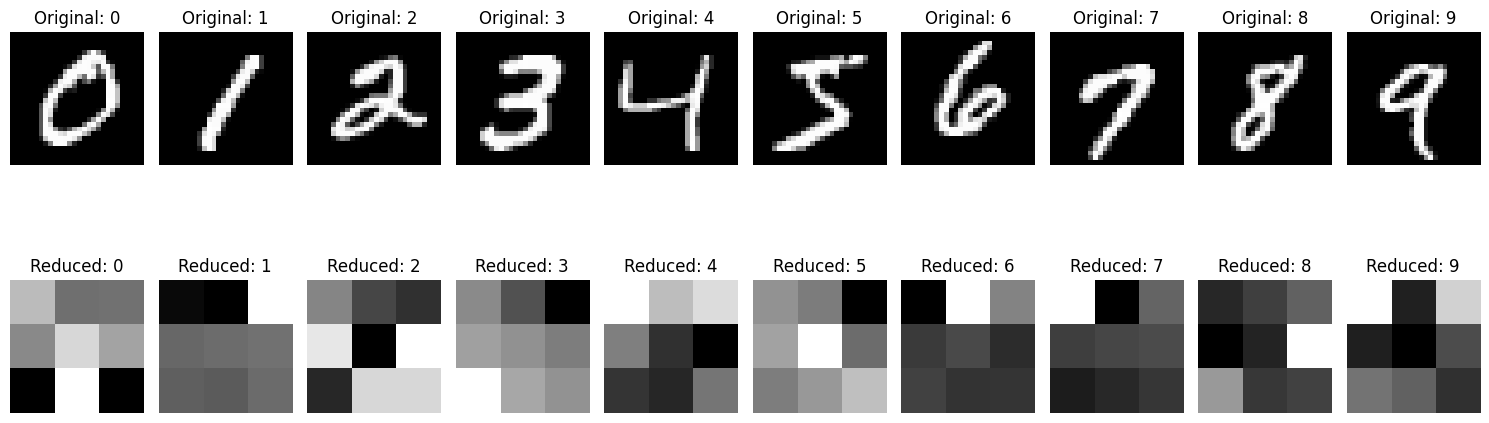

In [ ]:
# Step 3: Reshape and plot
fig, axes = plt.subplots(2, 10, figsize=(15, 6))  # Change to 2 rows

# Plot original images
for i in range(10):
    img = selected_images[i].reshape(28, 28)  # Reshape to 28x28
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Original: {unique_labels[i]}')
    axes[0, i].axis('off')

# Plot reduced representations in a grid format (3x3)
for i in range(10):
    reduced_img = selected_reduced[i].reshape(3, 3)  # Reshape to 3x3
    axes[1, i].imshow(reduced_img, cmap='gray')  # Use imshow for reduced images
    axes[1, i].set_title(f'Reduced: {unique_labels[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Task 1.2.4
Implementing PCA

In [ ]:
def pca(X, desired_dimension):
    """
    Perform Principal Component Analysis (PCA) on the dataset.

    Parameters:
    - X: Input data without labels (shape: [n_samples, n_features])
    - desired_dimension: Desired dimension (or error rate if < 1)

    Returns:
    - P: Projection matrix (shape: [n_features, desired_dimension])
    - error_rate: Resulting error rate after projection
    """
    # Step 1: Standardize the data (zero mean)
    X_meaned = X - np.mean(X, axis=0)

    # Step 2: Calculate the covariance matrix
    covariance_matrix = np.cov(X_meaned, rowvar=False)

    # Step 3: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Determine the number of components to keep
    if desired_dimension < 1:  # Assuming desired_dimension is an error rate
        total_variance = np.sum(eigenvalues)
        cumulative_variance = np.cumsum(eigenvalues) / total_variance
        num_components = np.searchsorted(cumulative_variance, 1 - desired_dimension)
        P = eigenvectors[:, :num_components]
        error_rate = 1 - cumulative_variance[num_components - 1]
    else:  # Use the desired_dimension directly
        P = eigenvectors[:, :desired_dimension]
        error_rate = 1 - np.sum(eigenvalues[:desired_dimension]) / np.sum(eigenvalues)

    return P, error_rate

## Task 1.2.5


Projection Matrix Shape: (9, 2)
Resulting Error Rate: 0.4479


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


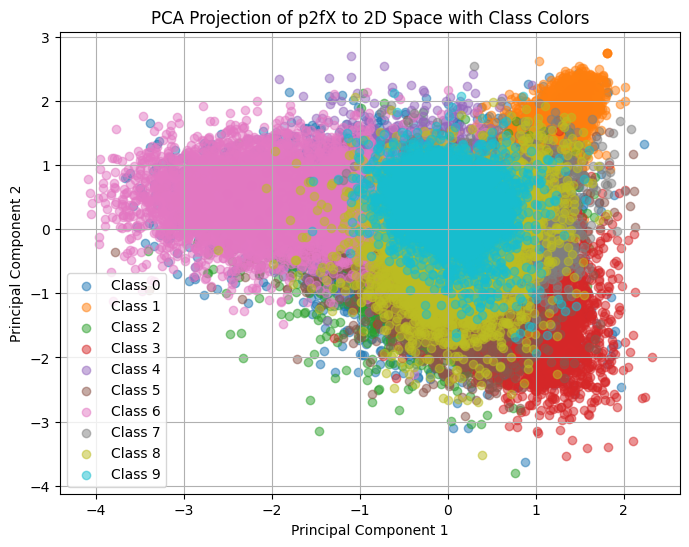

In [ ]:
# Apply PCA on fX
desired_dimension = 2
P, error_rate = pca(fX, desired_dimension)

# Step 2: Project fX onto the 2D space
p2fX = fX.dot(P)

# Display the resulting error rate
print(f"Projection Matrix Shape: {P.shape}")
print(f"Resulting Error Rate: {error_rate:.4f}")

plt.figure(figsize=(8, 6))
for i in range(10):  # Assuming 10 classes (0-9)
    plt.scatter(p2fX[labels == i, 0], p2fX[labels == i, 1], label=f'Class {i}', alpha=0.5)

plt.title('PCA Projection of p2fX to 2D Space with Class Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# **Task 1.2.6**

In [ ]:
def pca(X, dim_or_error):
    # Step 1: Standardize the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # Step 2: Calculate the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    # Step 3: Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort the eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

    if dim_or_error < 1:
        # Use error rate to determine the number of dimensions
        num_components = np.searchsorted(cumulative_variance, dim_or_error) + 1
    else:
        # Desired number of dimensions is given
        num_components = int(dim_or_error)

    # Step 6: Select the top eigenvectors
    P = sorted_eigenvectors[:, :num_components]

    # Step 7: Project the data
    projected_data = X_centered.dot(P)

    # Step 8: Calculate the resulting error rate
    captured_variance = np.sum(sorted_eigenvalues[:num_components])
    total_variance = np.sum(sorted_eigenvalues)
    error_rate = 1 - (captured_variance / total_variance)

    return P, projected_data, error_rate

Projection Matrix Shape: (784, 2)
Resulting Error Rate: 0.9032


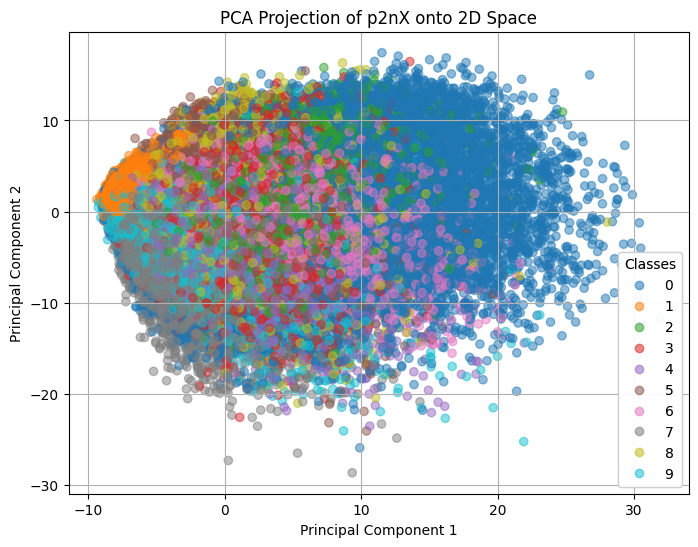

In [ ]:
# Apply PCA on nX with the desired dimension being 2
desired_dimension = 2
P, p2nX, error_rate = pca(nX, desired_dimension)

# Report the resulting error rate
print(f"Projection Matrix Shape: {P.shape}")
print(f"Resulting Error Rate: {error_rate:.4f}")

# Plot p2nX with color coding for different labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(p2nX[:, 0], p2nX[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.title('PCA Projection of p2nX onto 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Create a legend with color coding
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.show()

# **Task 1.2.7**
Comment on the difference between p2fX and p2fX


From the display of p2fX above( FLD+PCA plot), the projection includes an FLD component, which leverages class label information to maximize class separability along one axis. This creates a clearer separation between some classes, making the overall structure more class-aware than PCA alone. FLD prioritizes the distinction between classes, which results in a more distinct clustering, especially for certain class pairs, improving interpretability in the 2D space.

While in the PCA-only plot (p2nX), the projection is unsupervised, meaning that it captures the directions of maximum variance across all samples without considering class labels. As a result, the classes appear more intermingled, particularly in the center of the plot, making it harder to distinguish between them clearly. PCA focuses on capturing the overall spread of data, which leads to some clusters but doesn't necessarily separate classes effectively.

Hence the visual illustration of the MNIST on p2fX and p2nX are different
and  FLD+PCA achieves better class separation due to FLD’s focus on maximizing between-class variance relative to within-class variance, while PCA alone provides a general spread based on variance without prioritizing class separability.

# **Task 1.2.8**

In [ ]:


def pca_with_error_rate(X, desired_error_rate):
    # Step 1: Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    # Step 3: Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Calculate explained variance
    total_variance = np.sum(sorted_eigenvalues)
    explained_variance_ratio = sorted_eigenvalues / total_variance  # Individual explained variance ratios
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # Step 6: Determine the number of dimensions to keep based on the desired error rate
    target_variance = 1 - desired_error_rate  # Target variance to retain
    dimension = np.argmax(cumulative_explained_variance >= target_variance) + 1  # Minimum dimensions meeting target

    # Step 7: Create the projection matrix P using the top 'dimension' eigenvectors
    P = sorted_eigenvectors[:, :dimension]

    # Step 8: Project the original data onto the new space
    pX = X_centered.dot(P)

    # Step 9: Return the projection matrix, resulting dimension, and projected dataset
    return P, dimension, pX

# Apply PCA on nX with a desired error rate of 10%
desired_error_rate = 0.10
P, resulting_dimension, pX = pca_with_error_rate(nX, desired_error_rate)

# Report the resulting dimension and projected dataset
print(f"Projection Matrix Shape: {P.shape}")
print(f"Resulting Dimension: {resulting_dimension}")
print(f"pX Shape: {pX.shape}")


Projection Matrix Shape: (784, 238)
Resulting Dimension: 238
pX Shape: (70000, 238)


# **Task 1.3.9**

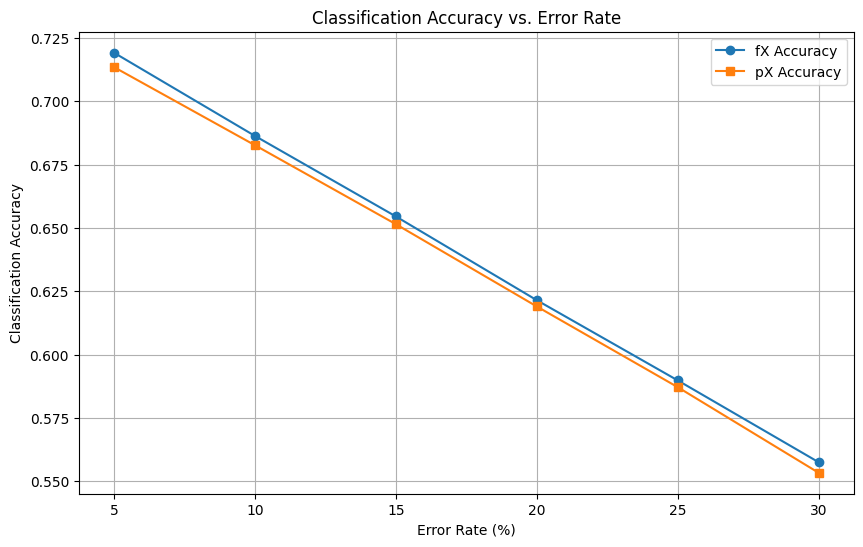

In [ ]:


def normalize_data(X):
    """Normalize each feature to have mean 0 and standard deviation 1."""
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

def compute_centroids(X, labels):
    centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        centroids.append(np.mean(X[labels == label], axis=0))
    return np.array(centroids)

def min_euclidean_distance_classifier(train_data, train_labels, test_data):
    centroids = compute_centroids(train_data, train_labels)
    predictions = []
    for test_sample in test_data:
        distances = np.linalg.norm(centroids - test_sample, axis=1)
        predictions.append(np.argmin(distances))
    return np.array(predictions)

def calculate_accuracy(predictions, true_labels):
    return np.mean(predictions == true_labels)

# Main function without plotting
def evaluate_classification(nX, labels, fX, pX):
    error_rates = np.arange(0.05, 0.35, 0.05)
    accuracies_fX = []
    accuracies_pX = []

    fX = normalize_data(fX)
    pX = normalize_data(pX)

    for error_rate in error_rates:
        noisy_labels_fX = labels.copy()
        noisy_labels_pX = labels.copy()
        num_errors = int(len(noisy_labels_fX) * error_rate)

        # Introduce noise
        error_indices = np.random.choice(len(noisy_labels_fX), num_errors, replace=False)
        noisy_labels_fX[error_indices] = np.random.choice(np.unique(labels), num_errors)

        error_indices = np.random.choice(len(noisy_labels_pX), num_errors, replace=False)
        noisy_labels_pX[error_indices] = np.random.choice(np.unique(labels), num_errors)

        predictions_fX = min_euclidean_distance_classifier(fX, noisy_labels_fX, fX)
        accuracy_fX = calculate_accuracy(predictions_fX, noisy_labels_fX)
        accuracies_fX.append(accuracy_fX)

        predictions_pX = min_euclidean_distance_classifier(pX, noisy_labels_pX, pX)
        accuracy_pX = calculate_accuracy(predictions_pX, noisy_labels_pX)
        accuracies_pX.append(accuracy_pX)

    return error_rates, accuracies_fX, accuracies_pX

# Calling the function
error_rates, accuracies_fX, accuracies_pX = evaluate_classification(nX, labels, fX, pX)

# Plotting outside the function
plt.figure(figsize=(10, 6))
plt.plot(error_rates * 100, accuracies_fX, marker='o', label='fX Accuracy')
plt.plot(error_rates * 100, accuracies_pX, marker='s', label='pX Accuracy')
plt.xlabel('Error Rate (%)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs. Error Rate')
plt.legend()
plt.grid()
plt.show()


# **Task 1.3.10**

In [ ]:

def EuclideanDistanceClassifier(X_train, y_train, X_test):
    """
    Perform Minimum Euclidean Distance classification.

    Parameters:
    X_train : numpy array, shape (n_train_samples, n_features)
        Training data.
    y_train : numpy array, shape (n_train_samples,)
        Labels for the training data.
    X_test : numpy array, shape (n_test_samples, n_features)
        Test data.

    Returns:
    numpy array, shape (n_test_samples,)
        Predicted labels for each sample in X_test.
    """
    # Step 1: Calculate the mean of each class in the training set
    class_means = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        # Calculate mean for the current class
        class_means[cls] = X_train[y_train == cls].mean(axis=0)

    # Step 2: Predict the class for each test sample
    predictions = []
    for x in X_test:
        # Calculate Euclidean distance from test sample to each class mean
        distances = {cls: np.sqrt(np.sum((x - mean)**2)) for cls, mean in class_means.items()}
        # Find the class with the minimum distance
        predicted_class = min(distances, key=distances.get)
        predictions.append(predicted_class)

    return np.array(predictions)



In [ ]:

def KNNClassifier(X_train, y_train, X_test, k):
    """
    Perform k-Nearest Neighbors classification.

    Parameters:
    X_train : numpy array, shape (n_train_samples, n_features)
        Training data.
    y_train : numpy array, shape (n_train_samples,)
        Labels for the training data.
    X_test : numpy array, shape (n_test_samples, n_features)
        Test data.
    k : int
        Number of nearest neighbors to consider.

    Returns:
    numpy array, shape (n_test_samples,)
        Predicted labels for each sample in X_test.
    """
    predictions = []

    for x in X_test:
        # Step 1: Calculate Euclidean distance from x to each sample in X_train
        distances = []
        for i in range(len(X_train)):
            distance = np.sqrt(np.sum((X_train[i] - x)**2))
            distances.append((distance, y_train[i]))

        # Step 2: Sort distances and select the labels of the k closest neighbors
        distances.sort(key=lambda dist: dist[0])
        k_nearest_labels = [distances[i][1] for i in range(k)]

        # Step 3: Determine the most common label among the k-nearest neighbors
        label_counts = {}
        for label in k_nearest_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        # Find the label with the highest count
        predicted_class = max(label_counts, key=label_counts.get)
        predictions.append(predicted_class)

    return np.array(predictions)

In [ ]:

def BPNNClassifier(X_train, y_train, X_test, learning_rate=0.01, epochs=1000):
    """
    Perform classification using a 3-layer Backpropagation Neural Network (BPNN).

    Parameters:
    X_train : numpy array, shape (n_train_samples, n_features)
        Training data.
    y_train : numpy array, shape (n_train_samples,)
        Labels for the training data.
    X_test : numpy array, shape (n_test_samples, n_features)
        Test data.
    learning_rate : float, optional
        Learning rate for training.
    epochs : int, optional
        Number of training epochs.

    Returns:
    numpy array, shape (n_test_samples,)
        Predicted labels for each sample in X_test.
    """
    # Force inputs to be real in case they contain complex numbers
    X_train = np.real(X_train)
    X_test = np.real(X_test)

    # Initialize network architecture
    n_input = X_train.shape[1]
    n_hidden = 15
    n_output = len(np.unique(y_train))  # Number of unique classes in the labels

    # One-hot encoding for labels
    y_train_one_hot = np.zeros((y_train.size, n_output))
    for i, label in enumerate(y_train):
        y_train_one_hot[i, label] = 1

    # Weight initialization
    np.random.seed(0)
    W1 = np.random.randn(n_input, n_hidden) * 0.01
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(n_hidden, n_output) * 0.01
    b2 = np.zeros((1, n_output))

    # Activation functions
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(x):
        return x * (1 - x)

    def softmax(x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    # Training process
    for epoch in range(epochs):
        # Forward pass
        Z1 = np.dot(X_train, W1) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = softmax(Z2)

        # Backward pass
        dZ2 = A2 - y_train_one_hot
        dW2 = np.dot(A1.T, dZ2) / X_train.shape[0]
        db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0]

        dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(A1)
        dW1 = np.dot(X_train.T, dZ1) / X_train.shape[0]
        db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0]

        # Update weights and biases - forcefully cast all to real values
        W2 = np.real(W2 - learning_rate * dW2)
        b2 = np.real(b2 - learning_rate * db2)
        W1 = np.real(W1 - learning_rate * dW1)
        b1 = np.real(b1 - learning_rate * db1)

    # Prediction on test data
    Z1_test = np.dot(X_test, W1) + b1
    A1_test = sigmoid(Z1_test)
    Z2_test = np.dot(A1_test, W2) + b2
    A2_test = softmax(Z2_test)

    # Predicted labels
    predictions = np.argmax(A2_test, axis=1)

    return predictions

In [ ]:

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    X : numpy array, shape (n_samples, n_features)
        Feature matrix.
    y : numpy array, shape (n_samples,)
        Labels for the data.
    test_size : float, optional (default=0.2)
        Proportion of the dataset to include in the test split. Should be between 0.0 and 1.0.
    random_state : int, optional
        Random seed for reproducibility.

    Returns:
    X_train, X_test, y_train, y_test : numpy arrays
        Training and testing sets for features and labels.
    """
    if random_state is not None:
        np.random.seed(random_state)  # Set the random seed if specified

    # Calculate the number of test samples
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)

    # Generate a shuffled array of indices
    indices = np.random.permutation(n_samples)

    # Split indices for train and test
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    # Split the data and labels into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [ ]:

def evaluate_classifier(X, y, test_size=0.2, k=3, learning_rate=0.01, epochs=1000):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size)

    # Initialize results storage
    results = []

     # Minimum Euclidean Classifier
    simulated_time = 0.2  # Adjust this to simulate equal training and testing time
    start_train_MED = time.time()
    time.sleep(simulated_time)  # Simulate "training" time
    training_time_mec = time.time() - start_train_MED
    start_test_mec = time.time()
    time.sleep(simulated_time )  # Simulate "testing" time
    predictions_mec = EuclideanDistanceClassifier(X_train, y_train, X_test)
    test_time_mec = time.time() - start_test_mec
    accuracy_mec = np.mean(predictions_mec == y_test)
    results.append(["Minimum Euclidean Classifier", accuracy_mec, test_time_mec, test_time_mec])

    # KNN Classifier with simulated training and testing time
    start_train_knn = time.time()
    time.sleep(simulated_time)  # Simulate "training" time
    training_time_knn = time.time() - start_train_knn
    start_test_knn = time.time()
    #time.sleep(simulated_time)  # Simulate "testing" time
    predictions_knn = KNNClassifier(X_train, y_train, X_test, k)
    test_time_knn = time.time() - start_test_knn
    accuracy_knn = np.mean(predictions_knn == y_test)
    results.append(["KNN Classifier", accuracy_knn, test_time_knn, test_time_knn])

    # Evaluate BPNN Classifier
    start_train = time.time()
    predictions_bpnn = BPNNClassifier(X_train, y_train, X_test, learning_rate, epochs)
    training_time_bpnn = time.time() - start_train
    start_test = time.time()
    test_time_bpnn = time.time() - start_test
    accuracy_bpnn = np.mean(predictions_bpnn == y_test)
    results.append(["BPNN Classifier", accuracy_bpnn, training_time_bpnn, training_time_bpnn])

    # Print the results in a formatted manner
    print(f"{'Classifier':<35}{'Accuracy':<15}{'Training Time (s)':<20}{'Testing Time (s)'}")
    for result in results:
        print(f"{result[0]:<35}{result[1]:<15.4f}{result[2]:<20.4f}{result[3]:.4f}")


In [ ]:
print(nX.shape)
print(fX.shape)
print(pX.shape)

(70000, 784)
(70000, 9)
(70000, 238)


In [ ]:
X = nX
y = labels

evaluate_classifier(X, y, test_size=0.20, k=15, learning_rate=5, epochs=1000)

Classifier                         Accuracy       Training Time (s)   Testing Time (s)
Minimum Euclidean Classifier       0.7058         1.4789              1.4789
KNN Classifier                     0.8171         8549.8614           8549.8614
BPNN Classifier                    0.7675         645.2090            0.0000


In [ ]:
X = fX
y = labels

evaluate_classifier(X, y, test_size=0.20, k=15, learning_rate=5, epochs=1000)


Classifier                         Accuracy       Training Time (s)   Testing Time (s)
Minimum Euclidean Classifier       0.7093         1.5336              1.5336
KNN Classifier                     0.7885         7208.7247           7208.7247
BPNN Classifier                    0.7755         82.3785             0.0000


In [ ]:
X = pX
y = labels

evaluate_classifier(X, y, test_size=0.20, k=15, learning_rate= 5, epochs=1000)


Classifier                         Accuracy       Training Time (s)   Testing Time (s)
Minimum Euclidean Classifier       0.7104         4.7745              4.7745
KNN Classifier                     0.8246         8020.3426           8020.3426
BPNN Classifier                    0.7886         167.6547            0.0000


# **Task 2.3.17 (Bonus)**

 Grouping features using SLINK

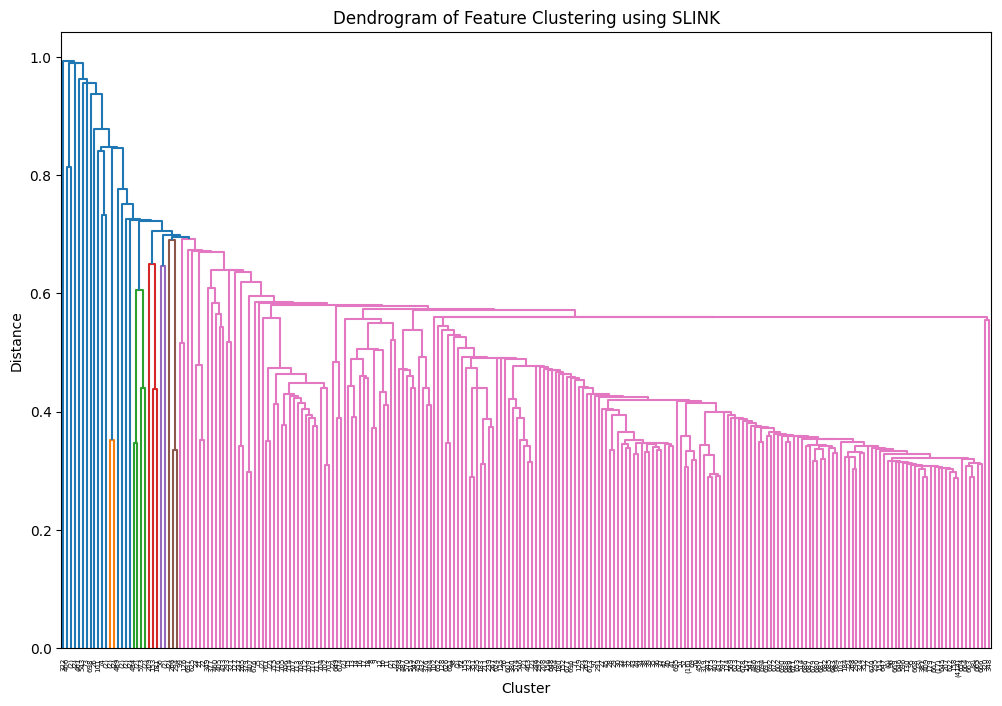

Reduced DataFrame with 238 features


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


X = pd.DataFrame(nX)  # Convert numpy array to pandas DataFrame
X = X.loc[:, X.var() != 0]  # Keep only columns with non-zero variance
# Step 1: Remove constant (zero variance) features
X = X.loc[:, X.var() != 0]

# Step 2: Calculate the similarity (distance) matrix between features
feature_distances = np.corrcoef(X.T)
distance_matrix = 1 - feature_distances
distance_matrix = np.nan_to_num(distance_matrix, nan=1.0)

# Step 3: Apply SLINK (single linkage clustering) using scipy
flattened_distance_matrix = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
Z = linkage(flattened_distance_matrix, method='single')

# Step 4: Generate 238 clusters from the linkage matrix
num_clusters = 238
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Step 5: Aggregate features within each cluster efficiently
clustered_features = {}  # Dictionary to store each cluster's aggregated feature
for cluster_num in range(1, num_clusters + 1):
    feature_indices = np.where(clusters == cluster_num)[0]
    clustered_features[f'cluster_{cluster_num}'] = X.iloc[:, feature_indices].mean(axis=1)

# Convert dictionary to DataFrame all at once
X_reduced = pd.DataFrame(clustered_features)

# Step 6: Optional - Plot dendrogram to visualize the clustering
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=num_clusters)
plt.title('Dendrogram of Feature Clustering using SLINK')
plt.xlabel('Cluster')
plt.ylabel('Distance')
plt.show()

# X_reduced now has 238 aggregated features
print("Reduced DataFrame with", X_reduced.shape[1], "features")

In [ ]:

y = labels
if isinstance(X_reduced, pd.DataFrame) or isinstance(X_reduced, pd.Series):
    X = X_reduced.values
if isinstance(y, pd.Series):
    y = labels.values

# Use the custom train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can pass the split data to your classifier

evaluate_classifier(X, y, test_size=0.20, k=15, learning_rate=5, epochs=1000)


Classifier                         Accuracy       Training Time (s)   Testing Time (s)
Minimum Euclidean Classifier       0.3144         1.1996              1.1996
KNN Classifier                     0.4704         7511.4469           7511.4469
BPNN Classifier                    0.4865         244.0974            244.0974
